# Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow_datasets as tfds
import tensorflow as tf
import re
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', font_scale=1.2)

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Data Acquisition & Loading

In [2]:
train_ds, test_ds = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    as_supervised=True
)

# Convert to pandas DataFrames
def convert_to_df(dataset):
    texts = [text.numpy().decode('utf-8') for text, _ in dataset]
    labels = [label.numpy() for _, label in dataset]
    return pd.DataFrame({'review': texts, 'sentiment': labels})

train_df = convert_to_df(train_ds)
test_df = convert_to_df(test_ds)

# Initial inspection
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("\nClass distribution (train):")
print(train_df['sentiment'].value_counts())
train_df.head()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.H7B0UN_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.H7B0UN_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.H7B0UN_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Train set shape: (25000, 2)
Test set shape: (25000, 2)

Class distribution (train):
sentiment
0    12500
1    12500
Name: count, dtype: int64


,review,sentiment
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1


# Exploratory Data Analysis (EDA)

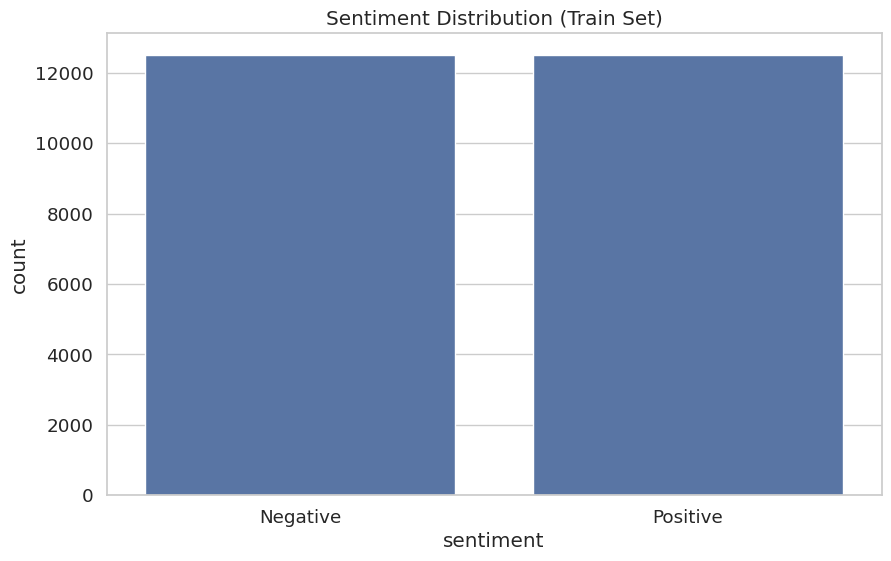

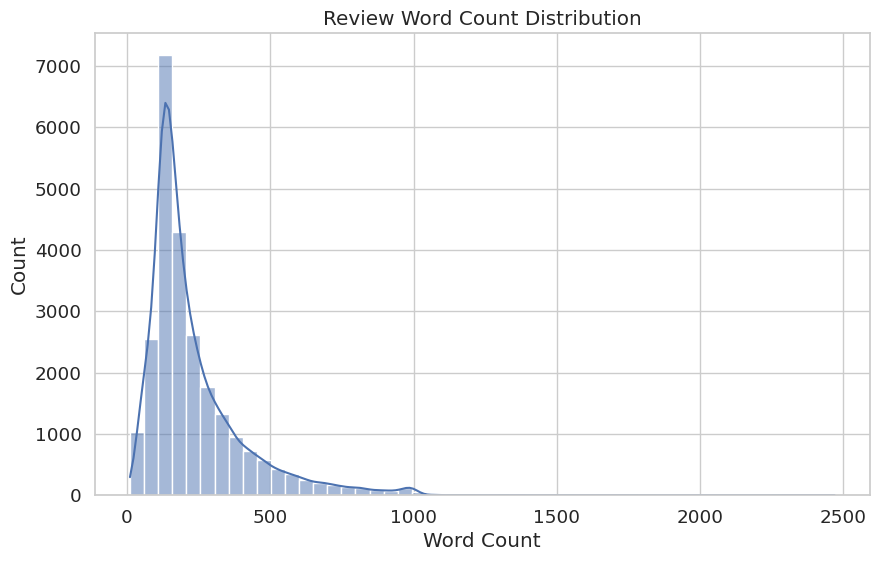

Average word count: 233.8
Median word count: 174.0

Missing values in train set:
review        0
sentiment     0
word_count    0
dtype: int64


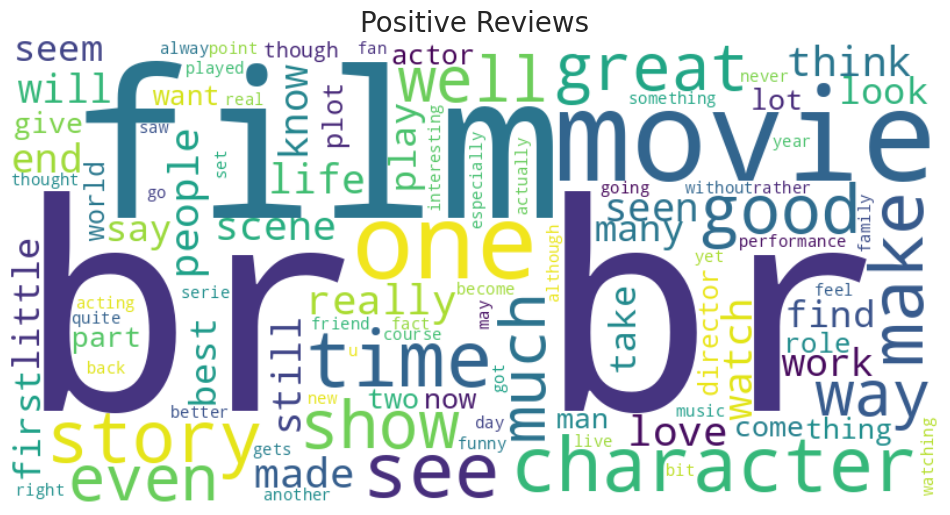

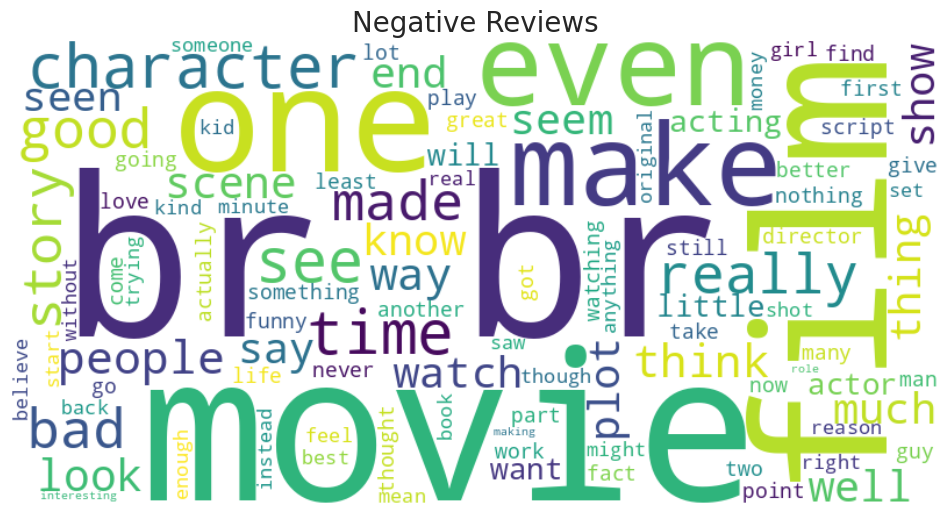

In [3]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=train_df)
plt.title('Sentiment Distribution (Train Set)')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

# Text statistics
train_df['word_count'] = train_df['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(train_df['word_count'], bins=50, kde=True)
plt.title('Review Word Count Distribution')
plt.xlabel('Word Count')
plt.show()

print(f"Average word count: {train_df['word_count'].mean():.1f}")
print(f"Median word count: {train_df['word_count'].median():.1f}")

# Check for missing values
print("\nMissing values in train set:")
print(train_df.isnull().sum())

# Word clouds
def plot_wordcloud(texts, title):
    text = " ".join(review for review in texts)
    wordcloud = WordCloud(
        max_words=100,
        background_color="white",
        width=800,
        height=400
    ).generate(text)
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis("off")
    plt.show()

plot_wordcloud(train_df[train_df['sentiment'] == 1]['review'], 'Positive Reviews')
plot_wordcloud(train_df[train_df['sentiment'] == 0]['review'], 'Negative Reviews')

# Text Preprocessing

In [4]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-alphabet characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and short words
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

# Apply preprocessing
train_df['cleaned_review'] = train_df['review'].apply(clean_text)
test_df['cleaned_review'] = test_df['review'].apply(clean_text)

# Verify cleaning
print("\nOriginal vs Cleaned Example:")
print("Original:", train_df['review'].iloc[0][:200] + "...")
print("Cleaned:", train_df['cleaned_review'].iloc[0][:100] + "...")


Original vs Cleaned Example:
Original: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting ...
Cleaned: absolutely terrible movie dont lured christopher walken michael ironside great actor must simply wor...


# Feature Engineering

In [5]:
# Split features and labels
X_train = train_df['cleaned_review']
y_train = train_df['sentiment']
X_test = test_df['cleaned_review']
y_test = test_df['sentiment']

# Bag-of-Words (BoW)
bow = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("BoW shape:", X_train_bow.shape)
print("TF-IDF shape:", X_train_tfidf.shape)

BoW shape: (25000, 5000)
TF-IDF shape: (25000, 5000)


# Model Building & Evaluation

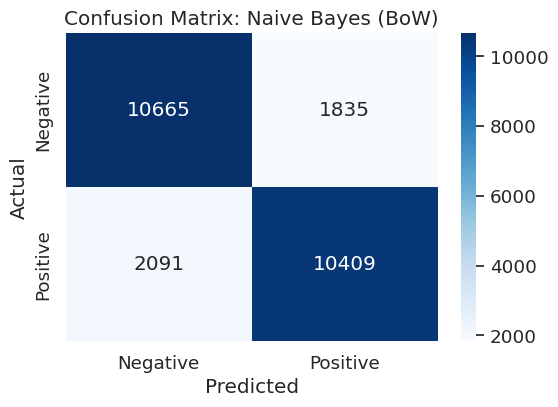

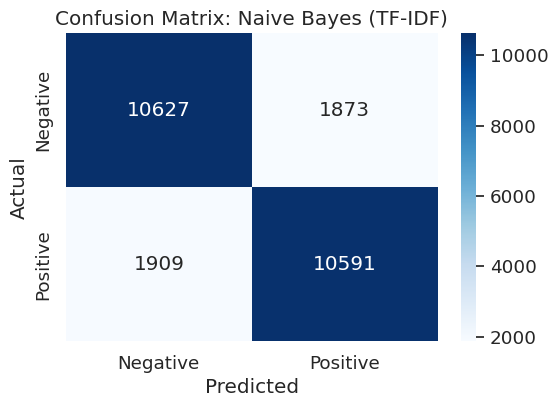

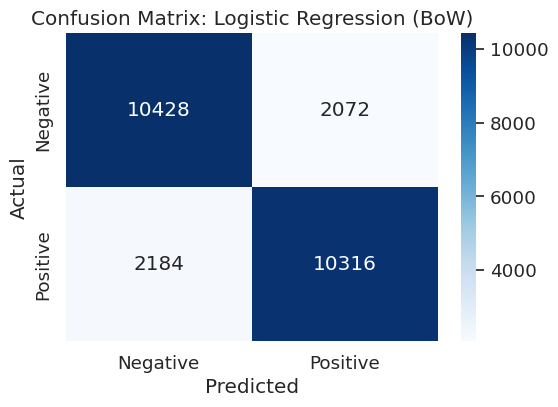

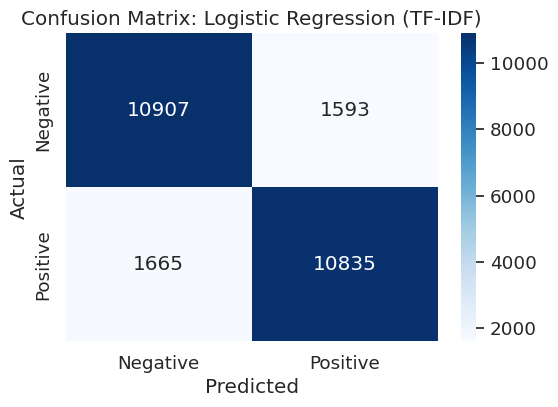

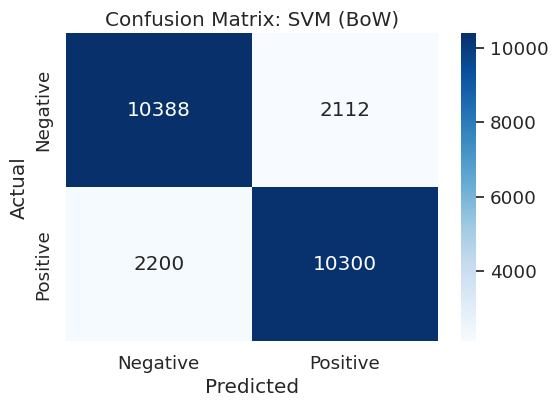

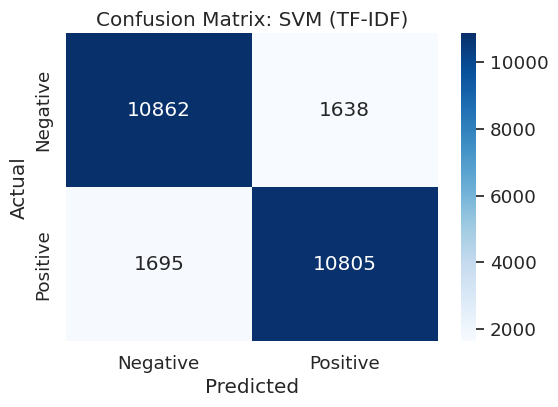


Model Performance Comparison:


,Model,Vectorizer,Accuracy,Precision,Recall,F1
3,Logistic Regression,TF-IDF,0.870,0.872,0.867,0.869
5,SVM,TF-IDF,0.867,0.868,0.864,0.866
1,Naive Bayes,TF-IDF,0.849,0.850,0.847,0.849
0,Naive Bayes,BoW,0.843,0.850,0.833,0.841
2,Logistic Regression,BoW,0.830,0.833,0.825,0.829
4,SVM,BoW,0.828,0.830,0.824,0.827


In [6]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, vectorizer_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = {
        'Model': model_name,
        'Vectorizer': vectorizer_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {model_name} ({vectorizer_name})')
    plt.show()

    return metrics

# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, C=10),
    'SVM': LinearSVC(random_state=42, max_iter=10000)
}

# Evaluate all combinations
results = []
for model_name, model in models.items():
    # BoW models
    results.append(evaluate_model(
        model, X_train_bow, X_test_bow, y_train, y_test,
        model_name, 'BoW'
    ))

    # TF-IDF models
    results.append(evaluate_model(
        model, X_train_tfidf, X_test_tfidf, y_train, y_test,
        model_name, 'TF-IDF'
    ))

# Display results
results_df = pd.DataFrame(results).round(3)
print("\nModel Performance Comparison:")
results_df.sort_values('F1', ascending=False)

# Basic Embeddings Model

In [7]:
!wget -q https://nlp.stanford.edu/data/glove.6B.zip -P data/
!unzip -q data/glove.6B.zip -d data/glove

# Load embeddings
embeddings_index = {}
with open('data/glove/glove.6B.50d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors.")

# Convert reviews to embedding vectors
def review_to_vec(review):
    words = review.split()
    vectors = [embeddings_index[w] for w in words
               if w in embeddings_index and len(w) > 2]
    return np.mean(vectors, axis=0) if vectors else np.zeros(50)

X_train_emb = np.array([review_to_vec(r) for r in train_df['cleaned_review']])
X_test_emb = np.array([review_to_vec(r) for r in test_df['cleaned_review']])

# Train Logistic Regression on embeddings
emb_model = LogisticRegression(max_iter=1000)
emb_model.fit(X_train_emb, y_train)
y_pred_emb = emb_model.predict(X_test_emb)

# Evaluate
emb_metrics = {
    'Model': 'GloVe Avg + LR',
    'Vectorizer': 'Embeddings',
    'Accuracy': accuracy_score(y_test, y_pred_emb),
    'Precision': precision_score(y_test, y_pred_emb),
    'Recall': recall_score(y_test, y_pred_emb),
    'F1': f1_score(y_test, y_pred_emb)
}

# Add to results
results.append(emb_metrics)
results_df = pd.DataFrame(results).round(3)
print("\nIncluding Embeddings Model:")
results_df.sort_values('F1', ascending=False)

Loaded 400000 word vectors.

Including Embeddings Model:


,Model,Vectorizer,Accuracy,Precision,Recall,F1
3,Logistic Regression,TF-IDF,0.870,0.872,0.867,0.869
5,SVM,TF-IDF,0.867,0.868,0.864,0.866
1,Naive Bayes,TF-IDF,0.849,0.850,0.847,0.849
0,Naive Bayes,BoW,0.843,0.850,0.833,0.841
2,Logistic Regression,BoW,0.830,0.833,0.825,0.829
4,SVM,BoW,0.828,0.830,0.824,0.827
6,GloVe Avg + LR,Embeddings,0.754,0.759,0.744,0.751


# Discussion & Conclusion

In [9]:
test_df['predicted'] = emb_model.predict(X_test_emb)  # Using best model
errors = test_df[test_df['sentiment'] != test_df['predicted']]

print("Examples of misclassified reviews:")
for i, row in errors.head(3).iterrows():
    print(f"\nActual: {'Positive' if row['sentiment'] else 'Negative'}")
    print(f"Review: {row['review'][:500]}...\n")

# Final results table
print("\nFinal Model Comparison:")
final_results = results_df[results_df['Vectorizer'] != 'Embeddings']  # Classic models only
best = final_results.sort_values('F1', ascending=False).iloc[0]
print(f"Best model: {best['Model']} with {best['Vectorizer']} (F1: {best['F1']:.3f})")

# Display sorted results
results_df.sort_values('F1', ascending=False, inplace=True)
results_df.style.background_gradient(cmap='Blues', subset=['Accuracy', 'F1'])

Examples of misclassified reviews:

Actual: Negative
Review: I saw this movie as part of a Billy Graham program. The church I attend was part of a community wide outreach to present God and Christianity to our community (Hartford, Ct. USA). I was one of the counselors who helped attendees (who were invited to come forward and make whatever kind of religious profession they wanted...and to follow up on them after the movie. As such, it did what it was supposed to do, and I personally found it to be a medium to strengthen my faith in God.I also found it to ...


Actual: Negative
Review: This film did well at the box office, and the producers of this mess thought the stars had such good chemistry in this that they cast them in the much darker screwball farce, The Gazebo. Frankly, I am shocked to see all the positive comments on this ludicrously plotted unfunny comedy. Both lead characters have the maturity of seven-year-olds and are much less interesting to spend time with. A veteran supp

,Model,Vectorizer,Accuracy,Precision,Recall,F1
3,Logistic Regression,TF-IDF,0.870000,0.872000,0.867000,0.869000
5,SVM,TF-IDF,0.867000,0.868000,0.864000,0.866000
1,Naive Bayes,TF-IDF,0.849000,0.850000,0.847000,0.849000
0,Naive Bayes,BoW,0.843000,0.850000,0.833000,0.841000
2,Logistic Regression,BoW,0.830000,0.833000,0.825000,0.829000
4,SVM,BoW,0.828000,0.830000,0.824000,0.827000
6,GloVe Avg + LR,Embeddings,0.754000,0.759000,0.744000,0.751000
